# Çözüm

2010LP33 asteroidi için $a = 2.55$ $AB$, $e=0,42$, $\tau=2458344.2343327492$ gün - 13 Ağustos 2018 17:37:28, $P=1491.04$ gün veriliyor. Yörüngesi tanımlı asteroidin enberi geçişinden bu yana çeşitli zamanlar için heliosentrik uzaklığını ve gerçek anomalisini ($\nu$) bulunuz.

Heliosentrik uzaklık, odaklarının birinde Güneş'in bulunduğu eliptik yörünge takip eden bir asteroidin $r$ uzaklığı bulunmalıdır.

## Önemli Formüller

$$ r = a(1-ecosE) $$
$$ \tan{\frac{\nu}{2}} = \sqrt{\frac{1 + e}{1 - e}} \tan{\frac{E}{2}} $$
$$ M = E - esinE = \frac{2\pi}{P}(t - \tau) $$

Çözüme giden adımlar:

1. Ortalama anomaliyi $M_e$ bul.
2. Kepler denklemini ($E - esinE$) çöz ve dış anomaliyi ($E$) bul. Analitik çözümü bulunmayan bu denklemin çözümünde Newton-Raphson nümerik yöntemi kullanılacak.
3. Tanjantlı fonksiyonda $E$'yi yerine koyarak gerçek anomaliyi $\nu$ bul.

In [1]:
import numpy as np
from astropy.time import Time
from datetime import datetime
import pandas as pd

In [2]:
a = 2.55                    # yarı-büyük eksen [AB]
e = 0.42                    # dışmerkezlik
tau = 2458344.2343327492    # enberiden geçme zamanı [JD]
p = 1491.04                 # yörünge dönemi (gün)

$P=1491.04$ gün, $\tau=2458344.2343327492$ Jülyen günü verildiği için önce bu değerleri $[sn]$ birimine, $a$ da astronomik birim uzaklığında verildiği için bunu da $[km]$ birimine çevirelim.

In [5]:
p = p * 24 * 60 * 60        # sn
tau = tau * 24 * 60 * 60    # sn
a = 2.55 * 149_597_871      # 1 AB = 149,597,871 km

Şimdi, $\tau$ değeri 13 Ağustos 2018'i verdiği için, biz de o günden bu yana her ayın 13'ünün Jülyen tarihini alalım.

In [6]:
dates = []
jd_array = []

def get_dates():
    start_date = datetime(2018, 9, 13)
    end_date = datetime(2025, 5, 13)
    jd_list = list()

    current_year = start_date.year
    current_month = start_date.month
    
    
    while True:
        current_date = datetime(current_year, current_month, 13)
        if current_date > end_date:
            break
        
        t = Time(current_date, scale='utc')
        jd_list.append((current_date.strftime("%Y-%m-%d"), t.jd))

        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1
            
    return jd_list

In [7]:
jd_list = get_dates()

for date, jd_value in jd_list:
    dates.append(date)
    jd_array.append(jd_value)
    
    
df = pd.DataFrame({
    "Date": dates,
    "JD": jd_array
})

In [8]:
# verilerle daha hızlı işlem yapmak için bir nüans: np.array

dates_array = np.array(dates)
jd_array = np.array(jd_array)

In [9]:
def get_mean_anomaly(t, tau=tau):
    return (2 * np.pi / p) * (t - tau)

Artık elimizde her ayın 13. günü için $JD$ verisi var, şimdi de bunları saniye birimine çevirelim.

In [10]:
df["JD Seconds"] = df["JD"] * 86400

In [11]:
df["Mean Anomaly"] = get_mean_anomaly(df["JD Seconds"].values)
df["Mean Anomaly"] = df["Mean Anomaly"] % (2 * np.pi)

Ortalama anomali $M_e$ teoride, $[0, 2\pi]$ aralığında olur, fakat $t$ değeri çok büyükse $M_e$ de büyük çıkabilir. Haliyle sonucu uygun aralıkta normalize etmek gerekecektir. Artık tabloda hem `df["Mean Anomaly]` hem de `df["Mean Anomaly Normalized]` olmak üzere iki adet ortalama anomali verisi var.

In [12]:
df

,Date,JD,JD Seconds,Mean Anomaly
0,2018-09-13,2458374.5,2.124036e+11,0.127538
1,2018-10-13,2458404.5,2.124061e+11,0.253957
2,2018-11-13,2458435.5,2.124088e+11,0.384590
3,2018-12-13,2458465.5,2.124114e+11,0.511009
4,2019-01-13,2458496.5,2.124141e+11,0.641642
...,...,...,...,...
76,2025-01-13,2460688.5,2.126035e+11,3.595460
77,2025-02-13,2460719.5,2.126062e+11,3.726093
78,2025-03-13,2460747.5,2.126086e+11,3.844084
79,2025-04-13,2460778.5,2.126113e+11,3.974717


## Newton-Raphson Metodu

Newton-Rapshon metodu, kısaca $f(E) = E - esinE$ ve $f'(E) = 1 - ecosE$ olmak üzere

$$ M < \pi, E = M + \frac{e}{2}$$
$$ M > \pi, E = M - \frac{e}{2}$$

başlangıç tahminleri ile verilen $E_0$ değerinden başlayarak

$$ E_{i+1} = E_i - \frac{E_i-esinE_i-M}{1-ecosE_i}$$

iterasyonunu gerçekleştiren yönteme denir. Burada

$$ E_{i+1} = E_i - \frac{f(E_i)}{f'(E_i)} $$

kontrolü yapılarak

$$ \lvert \frac{f(x_i)}{f'(x_i)} \rvert$$

ifadesi, $10^{-6}$ sayısından büyük ya da küçük olana kadar iterasyon yapılır.

In [13]:
def return_initial_guess(mean_anomaly):
    if mean_anomaly > np.pi:
        return mean_anomaly + (e / 2)
    else:
        return mean_anomaly - (e / 2)
    
def iterate_newton_raphson(df, verbose=False):
    tolerance_value = 1e-6
    roots = []
    for mean_anomaly_value in df["Mean Anomaly"]:
        step = return_initial_guess(mean_anomaly_value)
        i = 1
        while True:
            
            f = step - (e * np.sin(step)) - mean_anomaly_value
            f_derivative = 1 - (e * np.cos(step))
            control = f / f_derivative
            
            if verbose == True:
                print(f"{i:2d}. step; E: {step:10.6f}; control: {np.abs(control):10.6e}")
            
            step = step - control
            if np.abs(control) < tolerance_value:
                break
            i += 1
        roots.append(step)
        
    df["E"] = roots

Yukarıdaki hücrede `control` adlı değişken değişim miktarını belirten $ \frac{f(E_i)}{f'(E_i)} $ oranını verir. Bu değişken küçüldükçe her iterasyonda değişim miktarı da azalır (çözüme yakınsar).

In [14]:
iterate_newton_raphson(df)

$E$'den $\nu$'ye geçiş ise
$$ E = 2\arctan({\sqrt{\frac{1-e}{1+e}}\tan{\frac{\nu}{2}}}) $$
$$ \nu = 2\arctan({\sqrt{\frac{1+e}{1-e}}\tan{\frac{E}{2}}}) $$
bağıntıları yardımıyla yapılır.

In [15]:
square_root = np.sqrt((1+e)/(1-e))
df["True Anomaly Rad"] = 2 * np.arctan2(square_root * np.sin(df["E"] / 2), np.cos(df["E"] / 2))
df["True Anomaly Deg"] = np.rad2deg(df["True Anomaly Rad"])
df["M/2π"] = df["Mean Anomaly"] / (2 * np.pi)

## Heliosentrik Uzaklık

$$ r = a(1 - cosE) $$

In [16]:
df["Heliocentric Distance"] = a * (1 - e*np.cos(df["E"]))

Efemeris hesabı tamamlandı. Artık tüm tabloyu görmek için

In [17]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df

,Date,JD,JD Seconds,Mean Anomaly,E,True Anomaly Rad,True Anomaly Deg,M/2π,Heliocentric Distance
0,2018-09-13,2458374.5,2.124036e+11,0.127538,0.218635,0.340149,19.489121,0.020298,2.250694e+08
1,2018-10-13,2458404.5,2.124061e+11,0.253957,0.428452,0.656234,37.599413,0.040419,2.357375e+08
2,2018-11-13,2458435.5,2.124088e+11,0.384590,0.633072,0.947220,54.271705,0.061209,2.523036e+08
3,2018-12-13,2458465.5,2.124114e+11,0.511009,0.817322,1.191035,68.241260,0.081330,2.718562e+08
4,2019-01-13,2458496.5,2.124141e+11,0.641642,0.993600,1.407021,80.616389,0.102120,2.940466e+08
5,2019-02-13,2458527.5,2.124168e+11,0.772274,1.156792,1.592122,91.221868,0.122911,3.170217e+08
6,2019-03-13,2458555.5,2.124192e+11,0.890265,1.294315,1.737636,99.559198,0.141690,3.377391e+08
7,2019-04-13,2458586.5,2.124219e+11,1.020898,1.437153,1.879426,107.683172,0.162481,3.601260e+08
8,2019-05-13,2458616.5,2.124245e+11,1.147317,1.567315,2.001080,114.653411,0.182601,3.809167e+08
9,2019-06-13,2458647.5,2.124271e+11,1.277950,1.694729,2.113887,121.116815,0.203392,4.012801e+08


## 2010LP33 Asteroidinin Hareket Grafiği

Gerçek anomali $\nu$ ve heliosentrik uzaklık $r$ bilindiği için, kutupsal grafik çizilebilir.

In [18]:
import matplotlib.pyplot as plt

In [19]:
heliocentric_distance = df["Heliocentric Distance"].values
true_anomaly = df["True Anomaly Rad"].values

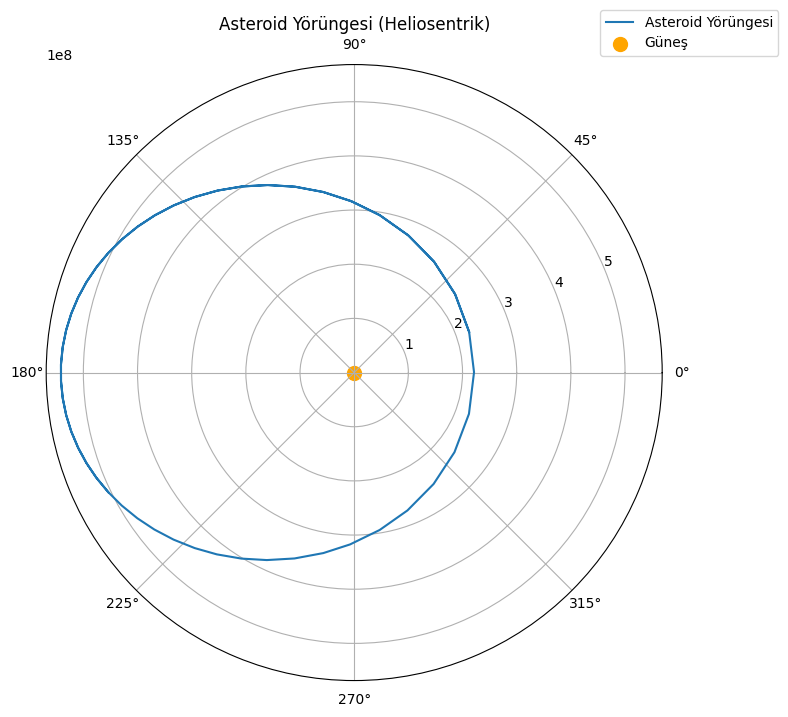

In [20]:
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

# asteroit yörüngesi için
ax.plot(true_anomaly, heliocentric_distance, label='Asteroid Yörüngesi')

# güneş merkezde olsun
ax.scatter(0, 0, color='orange', s=100, label='Güneş')

ax.set_title("Asteroid Yörüngesi (Heliosentrik)")
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()